In [2]:
import networkx as nx
import random
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
import pandas as pd

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


In [3]:

def create_dummy_topology_data(num_rings=10, nodes_per_ring=10, logical_rings_per_physical=3):
    """
    Create dummy topology data for testing
    
    Args:
        num_rings: Number of physical rings to create
        nodes_per_ring: Number of nodes per ring
        logical_rings_per_physical: Number of logical rings per physical ring
        
    Returns:
        DataFrame with topology data
    """
    data = []
    
    for pr_idx in range(num_rings):
        physical_ring = f"RING_{pr_idx}"
        block_name = f"BLOCK_{pr_idx}"  # One block per physical ring
        
        # Each physical ring has multiple logical rings from the same block
        for lr_idx in range(logical_rings_per_physical):
            logical_ring = f"LR_{pr_idx}_{lr_idx}"
            
            # Create a linear path for each logical ring (not a complete ring)
            for i in range(nodes_per_ring - 1):  # Connect nodes in a path, not a ring
                node_a = f"NODE_{pr_idx}_{lr_idx}_{i}"
                node_b = f"NODE_{pr_idx}_{lr_idx}_{i+1}"
                
                data.append({
                    'aendname': node_a,
                    'bendname': node_b,
                    'aendip': f"10.{pr_idx}.{lr_idx}.{i}",
                    'bendip': f"10.{pr_idx}.{lr_idx}.{i+1}",
                    'aendifIndex': i,
                    'bendifIndex': i+1,
                    'block_name': block_name,
                    'physicalringname': physical_ring,
                    'lrname': logical_ring
                })
            
            # Connect the first and last nodes to the block
            # First node connects to block
            data.append({
                'aendname': f"NODE_{pr_idx}_{lr_idx}_0",
                'bendname': block_name,
                'aendip': f"10.{pr_idx}.{lr_idx}.0",
                'bendip': f"10.{pr_idx}.99.99",  # Special IP for block
                'aendifIndex': 100 + lr_idx,
                'bendifIndex': 100 + lr_idx,
                'block_name': block_name,
                'physicalringname': physical_ring,
                'lrname': logical_ring
            })
            
            # Last node connects to block
            data.append({
                'aendname': f"NODE_{pr_idx}_{lr_idx}_{nodes_per_ring-1}",
                'bendname': block_name,
                'aendip': f"10.{pr_idx}.{lr_idx}.{nodes_per_ring-1}",
                'bendip': f"10.{pr_idx}.99.99",  # Special IP for block
                'aendifIndex': 200 + lr_idx,
                'bendifIndex': 200 + lr_idx,
                'block_name': block_name,
                'physicalringname': physical_ring,
                'lrname': logical_ring
            })
    
    # Add connections between blocks from different physical rings
    # for pr_idx in range(num_rings):
    #     if pr_idx < num_rings - 1:  # Connect to next physical ring
    #         # Connect this block to the next ring's block
    #         block_a = f"BLOCK_{pr_idx}"
    #         block_b = f"BLOCK_{pr_idx+1}"
            
    #         data.append({
    #             'aendname': block_a,
    #             'bendname': block_b,
    #             'aendip': f"10.{pr_idx}.99.99",
    #             'bendip': f"10.{pr_idx+1}.99.99",
    #             'aendifIndex': 300 + pr_idx,
    #             'bendifIndex': 300 + pr_idx + 1,
    #             'block_name': block_a,
    #             'physicalringname': f"RING_{pr_idx}",
    #             'lrname': "INTER_BLOCK"  # Inter-block connection
    #         })
    
    return pd.DataFrame(data)

In [4]:
topo_data = create_dummy_topology_data()

In [ ]:


def build_network_graph(topology_df):
    """Build a graph from topology_data_logical table"""
    
    G = nx.Graph()
    
    # Add nodes and edges with attributes
    for _, row in topology_df.iterrows():
        aend = row['aendname'].upper()
        bend = row['bendname'].upper()
        
        # Add node attributes
        G.add_node(aend, ip=row['aendip'], 
                   pr_id=row['physicalringname'], 
                   lr_id=row['lrname'],
                   block_name=row['block_name'],
                   failed=0)
        
        G.add_node(bend, ip=row['bendip'], 
                   pr_id=row['physicalringname'], 
                   lr_id=row['lrname'],
                   block_name=row['block_name'],
                   failed=0)
        
        # Add edge with attributes
        G.add_edge(aend, bend, 
                  physicalringname=row['physicalringname'], 
                  lrname=row['lrname'],
                  aendifIndex=row['aendifIndex'],
                  bendifIndex=row['bendifIndex'])
    
    return G


In [73]:
G = build_network_graph(topo_data)

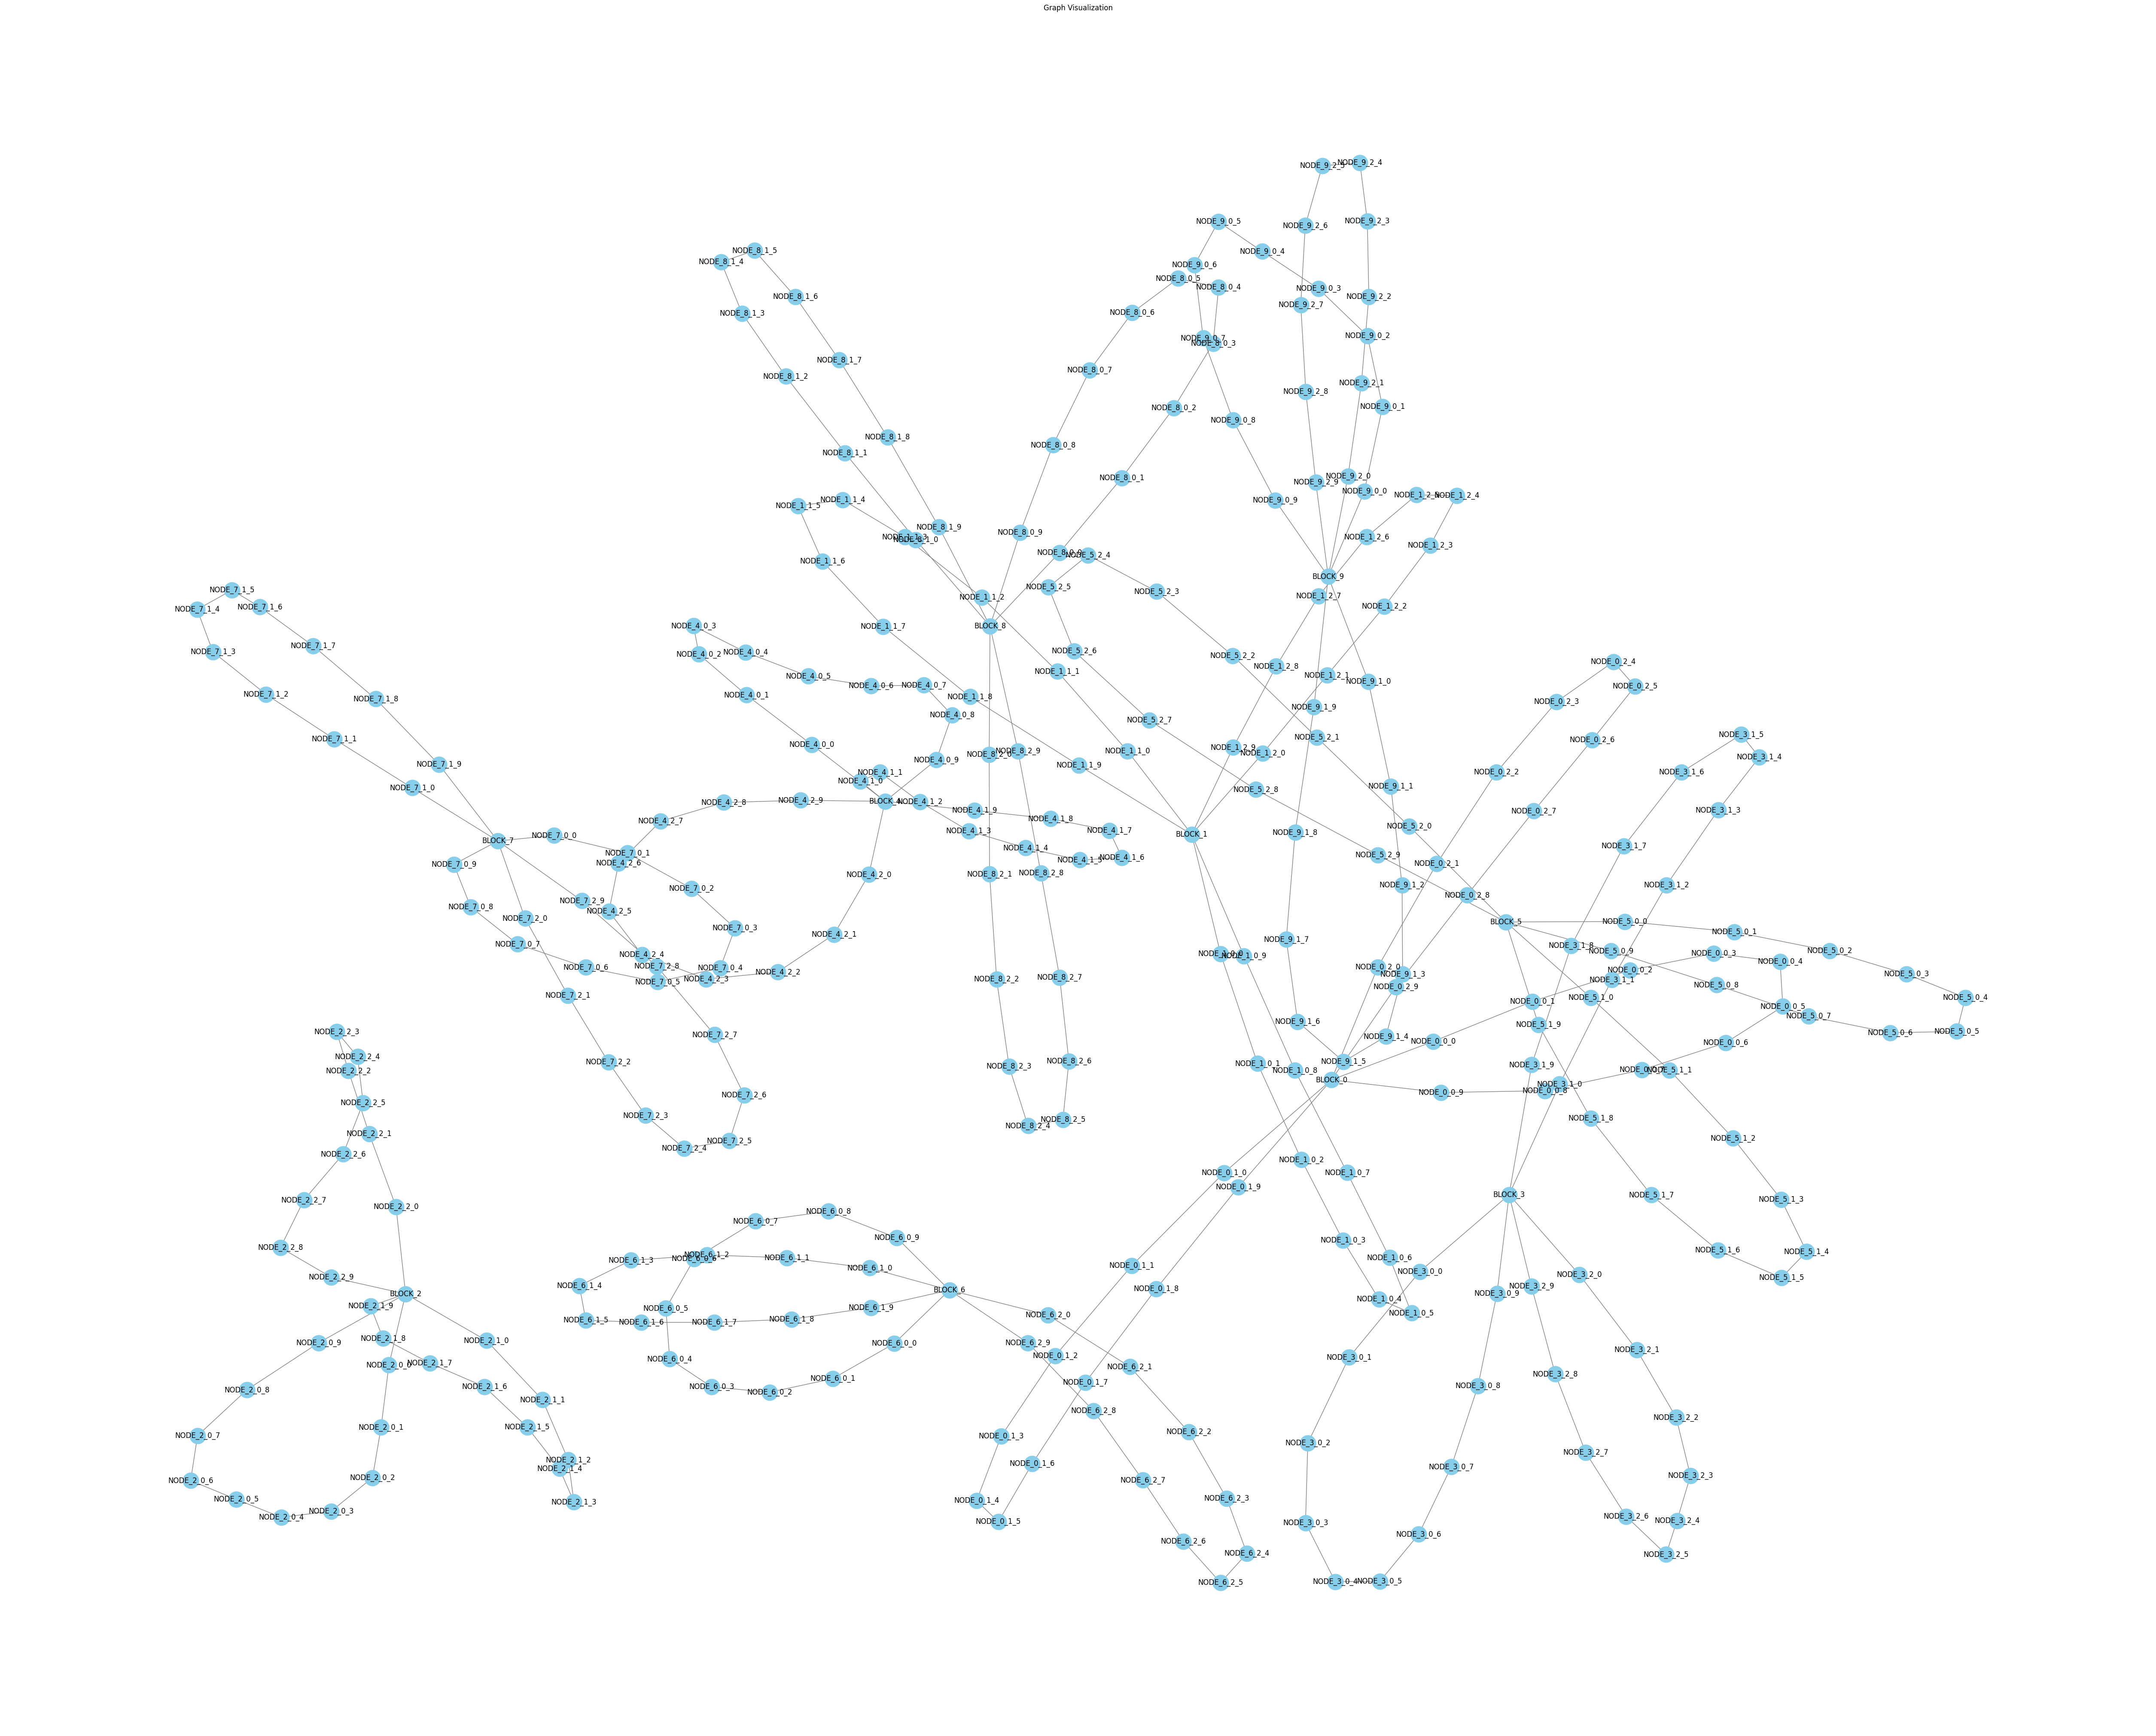

In [8]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph (replace this with your existing graph if you have one)


# Plot the graph
plt.figure(figsize=(50, 40))
pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='gray')
plt.title("Graph Visualization")
plt.show()

In [30]:
def build_rca_graph_from_dummy(topology_df):
    """
    Build a graph suitable for root cause analysis from dummy topology data,
    extracting pr_id and lr_id directly from node names.
    """
    G = nx.Graph()
    
    # Track nodes in each ring to assign positions later
    rings = {}
    
    # Add nodes and edges
    for _, row in topology_df.iterrows():
        aend = row['aendname']
        bend = row['bendname']
        
        # Process A-end node
        if aend.startswith("BLOCK_"):
            # Extract pr_id from block name (BLOCK_pr)
            parts = aend.split('_')
            pr_id = int(parts[1]) if len(parts) > 1 and parts[1].isdigit() else -1
            
            G.add_node(aend, 
                      ip=row['aendip'],
                      pr_id=pr_id,  # Use numeric pr_id
                      lr_id=-1,     # Blocks have no logical ring
                      position=-1,
                      is_block=True,
                      failed=0,
                      failure_time=-1)
        
        elif aend.startswith("NODE_"):
            # Extract components from node name (NODE_pr_lr_pos)
            parts = aend.split('_')
            if len(parts) >= 4:
                pr_id = int(parts[1]) if parts[1].isdigit() else -1
                lr_id = int(parts[2]) if parts[2].isdigit() else -1
                position = int(parts[3]) if parts[3].isdigit() else -1
                
                G.add_node(aend, 
                          ip=row['aendip'],
                          pr_id=pr_id,
                          lr_id=lr_id,
                          position=position,
                          is_block=False,
                          failed=0,
                          failure_time=-1)
                
                # Track nodes by ring
                ring_key = (pr_id, lr_id)
                if ring_key not in rings:
                    rings[ring_key] = set()
                rings[ring_key].add(aend)
        
        # Process B-end node with the same logic
        if bend.startswith("BLOCK_"):
            parts = bend.split('_')
            pr_id = int(parts[1]) if len(parts) > 1 and parts[1].isdigit() else -1
            
            G.add_node(bend, 
                      ip=row['bendip'],
                      pr_id=pr_id,
                      lr_id=-1,
                      position=-1,
                      is_block=True,
                      failed=0,
                      failure_time=-1)
        
        elif bend.startswith("NODE_"):
            parts = bend.split('_')
            if len(parts) >= 4:
                pr_id = int(parts[1]) if parts[1].isdigit() else -1
                lr_id = int(parts[2]) if parts[2].isdigit() else -1
                position = int(parts[3]) if parts[3].isdigit() else -1
                
                G.add_node(bend, 
                          ip=row['bendip'],
                          pr_id=pr_id,
                          lr_id=lr_id,
                          position=position,
                          is_block=False,
                          failed=0,
                          failure_time=-1)
                
                ring_key = (pr_id, lr_id)
                if ring_key not in rings:
                    rings[ring_key] = set()
                rings[ring_key].add(bend)
        
        # Add edge with attributes from row
        G.add_edge(aend, bend)
    
    print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Print ring statistics - now using numeric IDs
    ring_stats = {}
    for node, attrs in G.nodes(data=True):
        pr_id = attrs.get('pr_id', -1)
        lr_id = attrs.get('lr_id', -1)
        
        if isinstance(pr_id, int) and pr_id >= 0 and isinstance(lr_id, int) and lr_id >= 0:
            key = (pr_id, lr_id)
            if key not in ring_stats:
                ring_stats[key] = 0
            ring_stats[key] += 1
    
    print("\nRing statistics:")
    for ring, count in ring_stats.items():
        print(f"Ring PR={ring[0]}, LR={ring[1]}: {count} nodes")
    
    # Complete the rings by adding edges between first and last nodes
    for (pr_id, lr_id), nodes in rings.items():
        # Get nodes sorted by position
        ring_nodes = [(n, G.nodes[n]['position']) for n in nodes]
        ring_nodes.sort(key=lambda x: x[1])
        
        if len(ring_nodes) >= 2:
            # Connect first and last nodes to form a ring
            first_node = ring_nodes[0][0]
            last_node = ring_nodes[-1][0]
            
            # Don't add duplicate edges
            if not G.has_edge(first_node, last_node):
                G.add_edge(first_node, last_node)
                print(f"Added closing edge between {first_node} and {last_node}")
    
    return G

In [79]:
G = build_rca_graph_from_dummy(topo_data)

Created graph with 310 nodes and 330 edges

Ring statistics:
Ring PR=0, LR=0: 10 nodes
Ring PR=0, LR=1: 10 nodes
Ring PR=0, LR=2: 10 nodes
Ring PR=1, LR=0: 10 nodes
Ring PR=1, LR=1: 10 nodes
Ring PR=1, LR=2: 10 nodes
Ring PR=2, LR=0: 10 nodes
Ring PR=2, LR=1: 10 nodes
Ring PR=2, LR=2: 10 nodes
Ring PR=3, LR=0: 10 nodes
Ring PR=3, LR=1: 10 nodes
Ring PR=3, LR=2: 10 nodes
Ring PR=4, LR=0: 10 nodes
Ring PR=4, LR=1: 10 nodes
Ring PR=4, LR=2: 10 nodes
Ring PR=5, LR=0: 10 nodes
Ring PR=5, LR=1: 10 nodes
Ring PR=5, LR=2: 10 nodes
Ring PR=6, LR=0: 10 nodes
Ring PR=6, LR=1: 10 nodes
Ring PR=6, LR=2: 10 nodes
Ring PR=7, LR=0: 10 nodes
Ring PR=7, LR=1: 10 nodes
Ring PR=7, LR=2: 10 nodes
Ring PR=8, LR=0: 10 nodes
Ring PR=8, LR=1: 10 nodes
Ring PR=8, LR=2: 10 nodes
Ring PR=9, LR=0: 10 nodes
Ring PR=9, LR=1: 10 nodes
Ring PR=9, LR=2: 10 nodes
Added closing edge between NODE_0_0_0 and NODE_0_0_9
Added closing edge between NODE_0_1_0 and NODE_0_1_9
Added closing edge between NODE_0_2_0 and NODE_0_2_9


In [20]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv


In [10]:
def create_features_from_graph(G, node_list, focus_node):
    """
    Extract features from graph with pre-marked failures
    """
    features = []
    
    # Find all failed nodes and their times
    failed_nodes = []
    failure_times = []
    
    for node, attrs in G.nodes(data=True):
        if attrs.get('failed', 0) == 1:
            failed_nodes.append(node)
            failure_times.append(attrs.get('failure_time', 0))
    
    # Get ring of focus node
    focus_pr = G.nodes[focus_node]['pr_id']
    focus_lr = G.nodes[focus_node]['lr_id']
    focus_pos = G.nodes[focus_node]['position']
    
    # Sort failed nodes by position
    failed_nodes_sorted = sorted(failed_nodes, key=lambda n: G.nodes[n]['position'])
    if len(failed_nodes_sorted) >= 2:
        # Check if focus node is between two failed nodes
        for i in range(len(failed_nodes_sorted) - 1):
            node1 = failed_nodes_sorted[i]
            node2 = failed_nodes_sorted[i + 1]
            pos1 = G.nodes[node1]['position'] 
            pos2 = G.nodes[node2]['position']
            
            if (pos1 < focus_pos < pos2 and
                G.nodes[node1]['pr_id'] == focus_pr and
                G.nodes[node1]['lr_id'] == focus_lr and
                G.nodes[node2]['pr_id'] == focus_pr and
                G.nodes[node2]['lr_id'] == focus_lr):
                # Found the pair of failures causing this isolation
                G.nodes[focus_node]['between_failures'] = 1
                G.nodes[focus_node]['left_failure'] = node1
                G.nodes[focus_node]['right_failure'] = node2
                break
    
    for node in node_list:
        attrs = G.nodes[node]
        
        # Basic features
        is_failed = float(attrs.get('failed', 0))
        is_focus = float(node == focus_node)
        pr_id = attrs.get('pr_id', -1) / 10.0
        lr_id = attrs.get('lr_id', -1) / 10.0
        position = attrs.get('position', -1) / 10.0
        
        # Time-based features
        failure_time = attrs.get('failure_time', -1.0)
        
        # Relationship to focus node
        same_pr = float(attrs.get('pr_id', -2) == focus_pr)
        same_lr = float(attrs.get('lr_id', -2) == focus_lr)
        same_ring = same_pr * same_lr
        
        if same_ring and attrs.get('position', -1) >= 0 and focus_pos >= 0:
            # Relative position to focus node
            rel_pos = (attrs.get('position', 0) - focus_pos) / 10.0
        else:
            rel_pos = 0.0
        
        # If node is a potential root cause for the focus node
        is_potential_root = 0.0
        if is_failed and focus_node in G.nodes and 'between_failures' in G.nodes[focus_node]:
            if (node == G.nodes[focus_node].get('left_failure') or 
                node == G.nodes[focus_node].get('right_failure')):
                is_potential_root = 1.0
        
        # Create the feature vector
        node_features = [
            is_failed,
            failure_time,
            float(attrs.get('is_block', False)),
            pr_id,
            lr_id,
            position,
            same_pr,
            same_lr,
            same_ring,
            rel_pos,
            is_focus,
            is_potential_root
        ]
        
        features.append(node_features)
    
    return torch.tensor(features, dtype=torch.float)

In [ ]:
def create_root_cause_dataset(G, num_simulations=1000):
    """
    Create dataset for root cause analysis from a graph where failures
    are marked with node attributes.
    """
    # Create mapping between node names and indices
    node_list = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(node_list)}
    
    data_list = []
    rings = {}
    for node, attrs in G.nodes(data=True):
        pr_id = attrs.get('pr_id', -1)
        lr_id = attrs.get('lr_id', -1)
        if pr_id >= 0 and lr_id >= 0:
            key = (pr_id, lr_id)
            if key not in rings:
                rings[key] = []
            rings[key].append(node)
    
    valid_rings = [(k, v) for k, v in rings.items() if len(v) >= 4]
    G_sim = G.copy() 
    for _ in tqdm(range(num_simulations)):
        # Choose a random ring

        
        ring_key, ring_nodes = random.choice(valid_rings)
        
        # Choose two nodes to fail
        fail_nodes = random.sample(ring_nodes, 2)
        
        # Set failed attributes and timestamps
         # Create a copy for this simulation
        
        # Assign random timestamps (but ensure they're different)
        time1 = random.random()
        time2 = time1
        while abs(time2 - time1) < 0.01:  # Ensure distinct times
            time2 = random.random()
        
        # Set attributes for failed nodes
        G_sim.nodes[fail_nodes[0]]['failed'] = 1
        G_sim.nodes[fail_nodes[0]]['failure_time'] = time1
        
        G_sim.nodes[fail_nodes[1]]['failed'] = 1
        G_sim.nodes[fail_nodes[1]]['failure_time'] = time2
        
        # Determine root cause (most recent failure)
        root_cause = fail_nodes[0] if time1 > time2 else fail_nodes[1]
        
        # Find isolated nodes (between failures in the same ring)
        pos1 = G_sim.nodes[fail_nodes[0]]['position']
        pos2 = G_sim.nodes[fail_nodes[1]]['position']
        min_pos = min(pos1, pos2)
        max_pos = max(pos1, pos2)
        pr_id = G_sim.nodes[fail_nodes[0]]['pr_id']
        lr_id = G_sim.nodes[fail_nodes[0]]['lr_id']
        
        isolated_nodes = []
        for node in ring_nodes:
            node_pos = G_sim.nodes[node]['position']
            if (min_pos < node_pos < max_pos and 
                node not in fail_nodes and
                G_sim.nodes[node]['pr_id'] == pr_id and
                G_sim.nodes[node]['lr_id'] == lr_id):
                isolated_nodes.append(node)
        
        # Create training examples for each isolated node
        for isolated_node in isolated_nodes:
            # Create features from graph state
            x = create_features_from_graph(G_sim, node_list, isolated_node)
            
            # Create edge index
            edge_list = []
            for u, v in G_sim.edges():
                edge_list.append([node_to_idx[u], node_to_idx[v]])
                edge_list.append([node_to_idx[v], node_to_idx[u]])
            edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
            
            # Create target (one-hot encoding of root cause)
            y = torch.zeros(len(node_list))
            y[node_to_idx[root_cause]] = 1.0
            
            # Create Data object
            data = Data(
                x=x,
                edge_index=edge_index,
                y=y,
                focus_node_idx=torch.tensor([node_to_idx[isolated_node]],dtype=torch.long)
            )
            
            data_list.append(data)
            
        

    
    print(f"Created {len(data_list)} examples")
    return data_list, node_list, node_to_idx

In [107]:
class SimpleRootCauseGNN(torch.nn.Module):
    def __init__(self, in_features):
        super(SimpleRootCauseGNN, self).__init__()
        # Basic GNN layers
        self.conv1 = GCNConv(in_features, 64)
        self.conv2 = GCNConv(64, 64)
        
        # Output prediction layer
        self.classifier = nn.Linear(64, 1)
    
    def forward(self, x, edge_index, focus_node_idx=None):
        # Basic GNN pass
        h = F.relu(self.conv1(x, edge_index))
        h = F.dropout(h, p=0.2, training=self.training)
        h = F.relu(self.conv2(h, edge_index))
        
        # Simple prediction
        scores = self.classifier(h)
        
        return scores

In [108]:
def train_root_cause_model(data_list, num_epochs=50):
    """
    Train a simplified root cause model using batch_size=1
    """
    # Make sure we have data
    if len(data_list) == 0:
        print("No training data available")
        return None
        
    # Split data
    random.shuffle(data_list)
    train_size = int(0.8 * len(data_list))
    train_data = data_list[:train_size]
    val_data = data_list[train_size:]
    
    print(f"Training with {len(train_data)} examples, validating with {len(val_data)}")
    
    # Use batch_size=1 to avoid batching issues
    train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=1)
    
    # Initialize model
    in_features = data_list[0].x.size(1)
    model = SimpleRootCauseGNN(in_features)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Training loop
    best_acc = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for data in train_loader:
            optimizer.zero_grad()
            
            # Forward pass - simplified
            out = model(data.x, data.edge_index)
            
            # Get only the potential root nodes (where is_potential_root = 1)
            is_potential_root = data.x[:, -1] > 0.5
            
            if torch.any(is_potential_root):
                # Get prediction scores only for potential root nodes
                root_scores = out[is_potential_root].squeeze()
                root_labels = data.y[is_potential_root]
                
                # BCE loss on just these nodes
                loss = F.binary_cross_entropy_with_logits(root_scores, root_labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index)
                
                # Find nodes marked as potential roots
                is_potential_root = data.x[:, -1] > 0.5
                potential_indices = torch.where(is_potential_root)[0]
                
                if len(potential_indices) > 0:
                    # Get prediction for root cause (highest score among potential roots)
                    root_scores = out[potential_indices].squeeze()
                    pred_root_idx = potential_indices[torch.argmax(root_scores)]
                    
                    # Get true root cause (where y=1)
                    true_root_idx = torch.where(data.y == 1)[0][0]
                    
                    # Check if prediction matches ground truth
                    correct += (pred_root_idx == true_root_idx).item()
                
                total += 1
        
        val_acc = correct / max(1, total)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'root_cause_model.pt')
    
    return model

In [109]:
data_list, node_list, node_to_idx = create_root_cause_dataset(G, num_simulations=1000)

100%|██████████| 1000/1000 [00:03<00:00, 253.21it/s]

Created 2574 examples


In [110]:
train_root_cause_model(data_list)

Training with 2059 examples, validating with 515


/home/nms/.local/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Loss: 0.6007, Val Acc: 0.9029
Epoch 2/50, Loss: 0.5383, Val Acc: 0.8621
Epoch 3/50, Loss: 0.5249, Val Acc: 0.8660
Epoch 4/50, Loss: 0.5160, Val Acc: 0.9243
Epoch 5/50, Loss: 0.5096, Val Acc: 0.9204
Epoch 6/50, Loss: 0.5075, Val Acc: 0.8932
Epoch 7/50, Loss: 0.5007, Val Acc: 0.9243
Epoch 8/50, Loss: 0.5001, Val Acc: 0.8660
Epoch 9/50, Loss: 0.4957, Val Acc: 0.8990
Epoch 10/50, Loss: 0.4888, Val Acc: 0.9126
Epoch 11/50, Loss: 0.4853, Val Acc: 0.9379
Epoch 12/50, Loss: 0.4804, Val Acc: 0.9165
Epoch 13/50, Loss: 0.4847, Val Acc: 0.9379
Epoch 14/50, Loss: 0.4780, Val Acc: 0.9126
Epoch 15/50, Loss: 0.4742, Val Acc: 0.9379
Epoch 16/50, Loss: 0.4779, Val Acc: 0.9417
Epoch 17/50, Loss: 0.4687, Val Acc: 0.9146
Epoch 18/50, Loss: 0.4671, Val Acc: 0.9534
Epoch 19/50, Loss: 0.4683, Val Acc: 0.9437
Epoch 20/50, Loss: 0.4713, Val Acc: 0.9476
Epoch 21/50, Loss: 0.4674, Val Acc: 0.9301
Epoch 22/50, Loss: 0.4657, Val Acc: 0.9359
Epoch 23/50, Loss: 0.4590, Val Acc: 0.9573
Epoch 24/50, Loss: 0

KeyboardInterrupt: 

In [48]:
def predict_root_cause(model, G, node_list, node_to_idx, isolated_node):
    """Predict the root cause for an isolated node"""
    # Create features
    x = create_features_from_graph(G, node_list, isolated_node)
    
    # Create edge index
    edge_list = []
    for u, v in G.edges():
        edge_list.append([node_to_idx[u], node_to_idx[v]])
        edge_list.append([node_to_idx[v], node_to_idx[u]])
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        out = model(x, edge_index)
        
    # Get scores for potential roots
    is_potential_root = x[:, -1] > 0.5
    potential_indices = torch.where(is_potential_root)[0]
    
    if len(potential_indices) == 0:
        return None
        
    root_scores = out[potential_indices].squeeze()
    root_idx = potential_indices[torch.argmax(root_scores)]
    
    return node_list[root_idx]

In [55]:
def mark_nodes_as_failed(G, failed_nodes):
    H = G.copy()
    failure_times = 0.1
    for node in failed_nodes:
        G.nodes[node]['failed'] = 1
        G.nodes[node]['failure_time'] = failure_times
        failure_times += 0.1
    return H

In [144]:
failed_nodes = ['NODE_2_1_8','NODE_2_1_5','NODE_1_0_5','NODE_1_0_9',]
H = G.copy()
failure_times = 0.1
for node in failed_nodes:
    H.nodes[node]['failed'] = 1
    H.nodes[node]['failure_time'] = failure_times
    failure_times += 0.1

In [145]:
isolated_node = 'NODE_2_1_6'

in_features = 12  # Should match your feature dimension
model = SimpleRootCauseGNN(in_features) 

# Then load the state dictionary
model.load_state_dict(torch.load('root_cause_model.pt'))

# Now you can set it to evaluation mode
model.eval()

# Predict
result = predict_root_cause(model, H, node_list, node_to_idx, isolated_node)
print(f"Predicted root cause: {result}")

Predicted root cause: NODE_2_1_5


In [134]:
def create_features_from_graph(G, node_list, focus_node):
    """Extract features from graph with multiple failures"""
    features = []
    
    # Find all failed nodes in the same ring as the focus node
    focus_pr_id = G.nodes[focus_node].get('pr_id', -1)
    focus_lr_id = G.nodes[focus_node].get('lr_id', -1)
    focus_pos = G.nodes[focus_node].get('position', -1)
    
    # Collect all failed nodes in the same ring
    same_ring_failures = []
    for node, attrs in G.nodes(data=True):
        if (attrs.get('failed', 0) == 1 and 
            attrs.get('pr_id', -2) == focus_pr_id and
            attrs.get('lr_id', -2) == focus_lr_id):
            same_ring_failures.append((node, attrs.get('position', -1)))
    
    # Sort by position
    same_ring_failures.sort(key=lambda x: x[1])
    failed_nodes = [n[0] for n in same_ring_failures]
    
    # Find which pair is isolating this node
    isolating_pair = find_isolating_failures(G, focus_node, failed_nodes)
    
    # If found, mark them in the node attributes for later use
    if isolating_pair:
        G.nodes[focus_node]['left_failure'] = isolating_pair[0]
        G.nodes[focus_node]['right_failure'] = isolating_pair[1]
        G.nodes[focus_node]['between_failures'] = 1
    
    # Create features for all nodes
    for node in node_list:
        attrs = G.nodes[node]
        
        # Basic features
        is_failed = float(attrs.get('failed', 0))
        is_focus = float(node == focus_node)
        pr_id = attrs.get('pr_id', -1) / 10.0
        lr_id = attrs.get('lr_id', -1) / 10.0
        position = attrs.get('position', -1) / 10.0
        
        # Time-based features
        failure_time = attrs.get('failure_time', -1.0)
        
        # Relationship to focus node
        same_pr = float(attrs.get('pr_id', -2) == focus_pr_id)
        same_lr = float(attrs.get('lr_id', -2) == focus_lr_id)
        same_ring = same_pr * same_lr
        
        if same_ring and attrs.get('position', -1) >= 0 and focus_pos >= 0:
            # Relative position to focus node
            rel_pos = (attrs.get('position', 0) - focus_pos) / 10.0
        else:
            rel_pos = 0.0
        
        # If node is a potential root cause for the focus node
        is_potential_root = 0.0
        if isolating_pair and is_failed and node in isolating_pair:
            is_potential_root = 1.0
        
        # Create the feature vector
        node_features = [
            is_failed,
            failure_time,
            float(attrs.get('is_block', False)),
            pr_id,
            lr_id,
            position,
            same_pr,
            same_lr,
            same_ring,
            rel_pos,
            is_focus,
            is_potential_root
        ]
        
        features.append(node_features)
    
    return torch.tensor(features, dtype=torch.float)

def find_isolating_failures(G, focus_node, failed_nodes):
    """
    Find the pair of failed nodes that are isolating the focus node
    """
    if len(failed_nodes) < 2:
        return None
        
    focus_pos = G.nodes[focus_node].get('position', -1)
    
    # Sort failed nodes by position
    positions = [G.nodes[n].get('position', -1) for n in failed_nodes]
    failed_with_pos = list(zip(failed_nodes, positions))
    failed_with_pos.sort(key=lambda x: x[1])
    
    # Find the pair that sandwiches the focus node
    for i in range(len(failed_with_pos) - 1):
        pos1 = failed_with_pos[i][1]
        pos2 = failed_with_pos[i+1][1]
        
        if pos1 < focus_pos < pos2:
            return (failed_with_pos[i][0], failed_with_pos[i+1][0])
    
    return None

In [135]:
def create_root_cause_dataset(G, num_simulations=1000, max_failures_per_ring=4):
    """Create dataset with multiple failures per ring"""
    # Create mapping between node names and indices
    node_list = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(node_list)}
    
    # Extract rings once
    rings = {}
    for node, attrs in G.nodes(data=True):
        pr_id = attrs.get('pr_id', -1)
        lr_id = attrs.get('lr_id', -1)
        if not attrs.get('is_block', False) and pr_id >= 0 and lr_id >= 0:
            key = (pr_id, lr_id)
            if key not in rings:
                rings[key] = []
            rings[key].append(node)
    
    # Filter to rings with enough nodes
    valid_rings = [(k, v) for k, v in rings.items() if len(v) >= 4]
    if not valid_rings:
        print("No valid rings found with at least 4 nodes")
        return [], node_list, node_to_idx
    
    data_list = []
    
    # For each simulation
    for _ in tqdm(range(num_simulations)):
        # Choose a random ring
        ring_key, ring_nodes = random.choice(valid_rings)
        
        # Choose random number of failures (2-4)
        num_failures = random.randint(2, min(max_failures_per_ring, len(ring_nodes)-2))
        fail_nodes = random.sample(ring_nodes, num_failures)
        
        # Create a copy for simulation
        G_sim = G.copy()
        
        # Assign random timestamps
        failure_times = sorted([random.random() for _ in range(num_failures)])
        
        # Random assignment of times to nodes
        node_times = dict(zip(fail_nodes, failure_times))
        
        # Set failures in graph
        for node, time in node_times.items():
            G_sim.nodes[node]['failed'] = 1
            G_sim.nodes[node]['failure_time'] = time
        
        # Sort failed nodes by position
        failed_with_pos = [(n, G_sim.nodes[n].get('position', 0)) for n in fail_nodes]
        failed_with_pos.sort(key=lambda x: x[1])
        
        # For each pair of adjacent failures, find isolated nodes
        for i in range(len(failed_with_pos) - 1):
            node1, pos1 = failed_with_pos[i]
            node2, pos2 = failed_with_pos[i+1]
            
            # Find nodes between this pair
            isolated = []
            for node in ring_nodes:
                pos = G_sim.nodes[node].get('position', -1)
                if pos1 < pos < pos2 and node not in fail_nodes:
                    isolated.append(node)
                    # Mark the isolating pair
                    G_sim.nodes[node]['between_failures'] = 1
                    G_sim.nodes[node]['left_failure'] = node1
                    G_sim.nodes[node]['right_failure'] = node2
            
            # Determine root cause (most recent failure in pair)
            if node_times[node1] > node_times[node2]:
                root_cause = node1
            else:
                root_cause = node2
            
            # Create training examples for each isolated node
            for isolated_node in isolated:
                # Create features
                x = create_features_from_graph(G_sim, node_list, isolated_node)
                
                # Create edge index
                edge_list = []
                for u, v in G_sim.edges():
                    edge_list.append([node_to_idx[u], node_to_idx[v]])
                    edge_list.append([node_to_idx[v], node_to_idx[u]])
                edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
                
                # Create target (one-hot encoding of root cause)
                y = torch.zeros(len(node_list))
                y[node_to_idx[root_cause]] = 1.0
                
                # Create focus node index
                focus_idx = torch.tensor([node_to_idx[isolated_node]], dtype=torch.long)
                
                # Create Data object
                data = Data(
                    x=x,
                    edge_index=edge_index,
                    y=y,
                    focus_node_idx=focus_idx
                )
                
                data_list.append(data)
        
        # Clean up failures
        for node in fail_nodes:
            G_sim.nodes[node]['failed'] = 0
            if 'failure_time' in G_sim.nodes[node]:
                del G_sim.nodes[node]['failure_time']
    
    print(f"Created {len(data_list)} examples")
    return data_list, node_list, node_to_idx

In [136]:
data_list, node_list, node_to_idx = create_root_cause_dataset(G, num_simulations=1000)

100%|██████████| 1000/1000 [00:05<00:00, 185.17it/s]

Created 3265 examples


In [137]:
train_root_cause_model(data_list)

Training with 2612 examples, validating with 653


/home/nms/.local/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Loss: 0.6274, Val Acc: 0.8913
Epoch 2/50, Loss: 0.5599, Val Acc: 0.8851
Epoch 3/50, Loss: 0.5517, Val Acc: 0.8943
Epoch 4/50, Loss: 0.5423, Val Acc: 0.8928
Epoch 5/50, Loss: 0.5400, Val Acc: 0.9112
Epoch 6/50, Loss: 0.5334, Val Acc: 0.9234
Epoch 7/50, Loss: 0.5386, Val Acc: 0.9188
Epoch 8/50, Loss: 0.5308, Val Acc: 0.8698
Epoch 9/50, Loss: 0.5289, Val Acc: 0.9204
Epoch 10/50, Loss: 0.5266, Val Acc: 0.9234
Epoch 11/50, Loss: 0.5268, Val Acc: 0.9449
Epoch 12/50, Loss: 0.5220, Val Acc: 0.9342
Epoch 13/50, Loss: 0.5224, Val Acc: 0.9296
Epoch 14/50, Loss: 0.5183, Val Acc: 0.9035
Epoch 15/50, Loss: 0.5195, Val Acc: 0.9311
Epoch 16/50, Loss: 0.5157, Val Acc: 0.9173
Epoch 17/50, Loss: 0.5154, Val Acc: 0.9219
Epoch 18/50, Loss: 0.5141, Val Acc: 0.9265
Epoch 19/50, Loss: 0.5125, Val Acc: 0.9449
Epoch 20/50, Loss: 0.5087, Val Acc: 0.9280
Epoch 21/50, Loss: 0.5102, Val Acc: 0.9510
Epoch 22/50, Loss: 0.5061, Val Acc: 0.9265
Epoch 23/50, Loss: 0.5078, Val Acc: 0.9188
Epoch 24/50, Loss: 0

KeyboardInterrupt: 

In [ ]:
def analyze_network_root_causes(G, model_path='root_cause_model.pt'):
    """
    Analyze a network with multiple failures to determine root causes for all isolations
    """
    # Create node list and mapping
    node_list = list(G.nodes())
    node_to_idx = {node: i for i, node in enumerate(node_list)}
    
    # Find all failed nodes
    failed_nodes = [node for node, attrs in G.nodes(data=True) 
                   if attrs.get('failed', 0) == 1]
    
    print(f"Found {len(failed_nodes)} failed nodes: {failed_nodes}")
    
    if len(failed_nodes) < 2:
        print("Need at least 2 failed nodes to determine isolations")
        return {}
    
    # Group nodes by ring
    rings = {}
    for node, attrs in G.nodes(data=True):
        if not attrs.get('is_block', False):
            pr_id = attrs.get('pr_id', -1)
            lr_id = attrs.get('lr_id', -1)
            if pr_id >= 0 and lr_id >= 0:
                key = (pr_id, lr_id)
                if key not in rings:
                    rings[key] = []
                rings[key].append((node, attrs.get('position', -1)))
    
    # Sort nodes in each ring by position
    for key in rings:
        rings[key].sort(key=lambda x: x[1])
    
    # Find isolated nodes in each ring
    isolated_nodes = []
    
    for ring_key, nodes_with_pos in rings.items():
        nodes = [n[0] for n in nodes_with_pos]
        
        # Get failed nodes in this ring
        ring_failed = []
        for node in failed_nodes:
            attrs = G.nodes[node]
            if (attrs.get('pr_id', -2) == ring_key[0] and 
                attrs.get('lr_id', -2) == ring_key[1]):
                ring_failed.append((node, attrs.get('position', -1)))
        
        # Skip if less than 2 failures
        if len(ring_failed) < 2:
            continue
        
        # Sort by position
        ring_failed.sort(key=lambda x: x[1])
        
        # For each pair of adjacent failures, find isolated nodes
        for i in range(len(ring_failed) - 1):
            node1, pos1 = ring_failed[i]
            node2, pos2 = ring_failed[i+1]
            
            # Find nodes between these positions
            for node, pos in nodes_with_pos:
                if pos1 < pos < pos2 and node not in failed_nodes:
                    isolated_nodes.append(node)
                    # Mark isolating failures for later
                    G.nodes[node]['between_failures'] = 1
                    G.nodes[node]['left_failure'] = node1
                    G.nodes[node]['right_failure'] = node2
    
    print(f"Found {len(isolated_nodes)} isolated nodes: {isolated_nodes}")
    
    if not isolated_nodes:
        return {}
    
    # Load the model
    in_features = 12  # Match your feature vector length
    model = SimpleRootCauseGNN(in_features)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # For each isolated node, predict root cause
    results = {}
    
    for isolated_node in isolated_nodes:
        root_cause = predict_root_cause(model, G, node_list, node_to_idx, isolated_node)
        results[isolated_node] = root_cause
        
        # Print result with evidence
        left = G.nodes[isolated_node].get('left_failure', None)
        right = G.nodes[isolated_node].get('right_failure', None)
        
        print(f"\nIsolated node: {isolated_node}")
        if left and right:
            left_time = G.nodes[left].get('failure_time', 'unknown')
            right_time = G.nodes[right].get('failure_time', 'unknown')
            print(f"  Isolated between: {left} (time: {left_time:.2f}) and {right} (time: {right_time:.2f})")
            print(f"  Predicted root cause: {root_cause}")
    
    return results